# Weather Forecast

In [17]:
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import pickle
import re

In [2]:
print(tf.__version__)
print(np.__version__)
print(pd.__version__)

2.17.1
1.26.4
2.2.3


In [3]:
# Get the API for OpenMeteo
def fetch_weather_data(latitude, longitude, start_date, end_date):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m,precipitation"
    }
    response = requests.get(url, params=params)
    return response.json()


In [4]:
# Classify weather
def process_weather_data(data):
    import numpy as np
    from datetime import datetime

    times = [datetime.strptime(t, "%Y-%m-%dT%H:%M") for t in data["hourly"]["time"]]
    precipitation = np.array(data["hourly"]["precipitation"])

    daily_precipitation = {}
    for time, rain in zip(times, precipitation):
        date = time.date()
        if date not in daily_precipitation:
            daily_precipitation[date] = 0
        daily_precipitation[date] += rain

    rainy_days = {date: rain > 0.1 for date, rain in daily_precipitation.items()}

    total_days = len(rainy_days)
    rainy_count = sum(rainy_days.values())
    if rainy_count / total_days > 0.5:
        weather_summary = "Mostly rainy"
    elif rainy_count / total_days > 0.25:
        weather_summary = "Partly rainy"
    else:
        weather_summary = "Mostly sunny"

    return rainy_days, weather_summary


In [5]:
# Plot
def plot_weather_with_annotations(data, rainy_days):
    import matplotlib.pyplot as plt
    from datetime import datetime

    times = [datetime.strptime(t, "%Y-%m-%dT%H:%M") for t in data["hourly"]["time"]]
    temperatures = data["hourly"]["temperature_2m"]
    precipitation = data["hourly"]["precipitation"]

    plt.figure(figsize=(12, 6))
    plt.plot(times, temperatures, label="Temperature (°C)", color="orange", linewidth=2)
    plt.fill_between(times, precipitation, label="Precipitation (mm)", color="blue", alpha=0.3)

    for date, is_rainy in rainy_days.items():
        if is_rainy:
            plt.axvspan(datetime.combine(date, datetime.min.time()),
                        datetime.combine(date, datetime.max.time()),
                        color="gray", alpha=0.2, label="Rainy Day" if "Rainy Day" not in plt.gca().get_legend_handles_labels()[1] else None)

    plt.title("Weather Forecast (Easy to Interpret)")
    plt.xlabel("Time")
    plt.ylabel("Weather Metrics")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [6]:
# Read location data
csv_url = "https://raw.githubusercontent.com/ajisakarsyi/CulTour/refs/heads/main/asset/province_latitude_longitude_data.csv"

try:
    df = pd.read_csv(csv_url, skiprows=1, names=["country", "province", "latitude", "longitude"])
except Exception as e:
    print(f"Error reading the CSV file: {e}")
    exit()

In [7]:
try:
    df['province'] = df['province'].fillna('').astype(str)
    
    province_input = input("Enter the province name: ").strip().lower()
    
    province_row = df[df['province'].apply(lambda x: x.lower() == province_input)]
    
    if province_row.empty:
        print("Province not found in the CSV file.")
        exit()
    
    latitude = province_row.iloc[0]['latitude']
    longitude = province_row.iloc[0]['longitude']
    print(f"Latitude={latitude}, Longitude={longitude}")
except Exception as e:
    print(f"Error finding province: {e}")
    exit()


Latitude=-8.3405, Longitude=115.092


In [8]:
# Read travel start date and end date
try:
    start_date = input("Enter the start date (YYYY-MM-DD): ").strip()
    end_date = input("Enter the end date (YYYY-MM-DD): ").strip()
    print(f"Using Start Date: {start_date}, End Date: {end_date}")
except Exception as e:
    print(f"Error reading dates: {e}")
    exit()

Using Start Date: 2024-11-01, End Date: 2024-11-20


Weather Summary: Mostly rainy


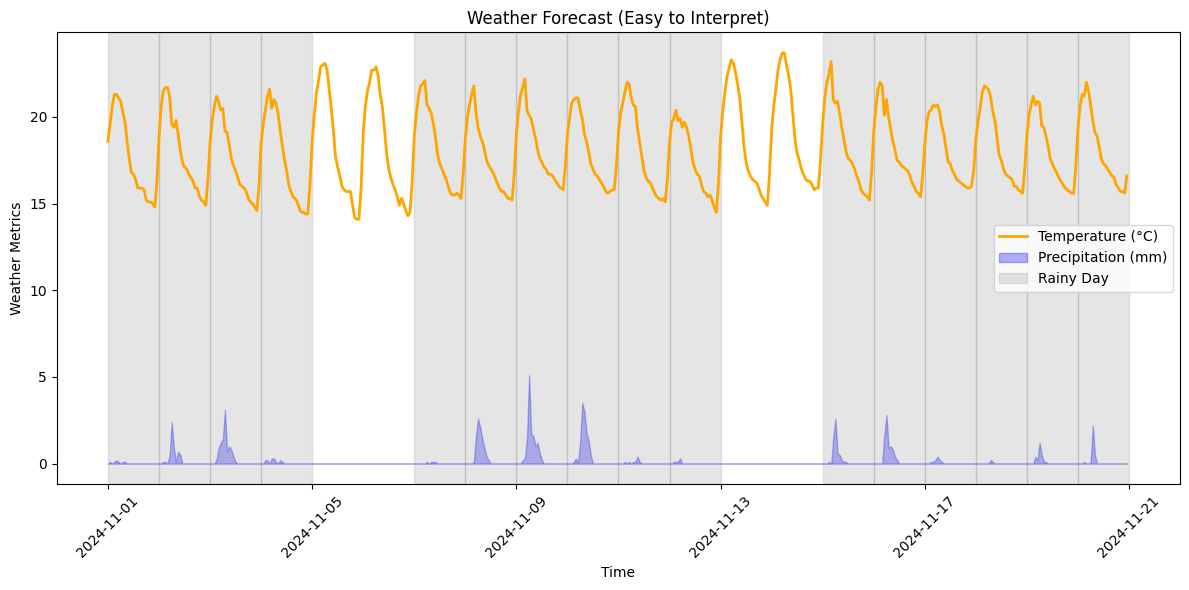

In [9]:
# Print time-series graph
try:
    weather_data = fetch_weather_data(latitude, longitude, start_date, end_date)
    rainy_days, weather_summary = process_weather_data(weather_data)
    print(f"Weather Summary: {weather_summary}")
    plot_weather_with_annotations(weather_data, rainy_days)
except Exception as e:
    print(f"Error in weather processing: {e}")
    exit()

# Chatbot Recommendations Based of The Weather

In [10]:
# Function to load data from a URL
def load_data_from_url(file_url):
    response = requests.get(file_url)
    response.raise_for_status()

    lines = response.text.splitlines()
    input_data = []
    output_data = []
    mode = None 

    for line in lines:
        line = line.strip()
        if line == "[Input]":
            mode = "input"
            continue
        elif line == "[Output]":
            mode = "output"
            continue
        elif not line:
            continue

        if mode == "input":
            input_data.append(line)
        elif mode == "output":
            output_data.append(line)

    return {"Input": input_data, "Output": output_data}

file_url = "https://raw.githubusercontent.com/ajisakarsyi/CulTour/refs/heads/main/asset/weather_response_data.txt"  

data = load_data_from_url(file_url)


In [11]:
# Tokenize
# Special tokens
start_token = "[START]"
end_token = "[END]"

# Add special tokens to the outputs
data["Output"] = [f"{start_token} {text} {end_token}" for text in data["Output"]]

tokenizer = Tokenizer(filters='', oov_token="<OOV>")
tokenizer.fit_on_texts([start_token, end_token] + data["Input"] + data["Output"])

if start_token not in tokenizer.word_index:
    tokenizer.word_index[start_token] = len(tokenizer.word_index) + 1
if end_token not in tokenizer.word_index:
    tokenizer.word_index[end_token] = len(tokenizer.word_index) + 1



In [12]:
# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Texts to sequences
input_sequences = tokenizer.texts_to_sequences(data["Input"])
output_sequences = tokenizer.texts_to_sequences(data["Output"])

# Padding
max_input_len = max(len(seq) for seq in input_sequences)
max_output_len = max(len(seq) for seq in output_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_len, padding='post')

input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

# Decodeer target data
decoder_target_data = np.zeros_like(output_sequences)
decoder_target_data[:, :-1] = output_sequences[:, 1:]



In [22]:
print(max_input_len)

2


In [13]:
    # Model parameters
    embedding_dim = 128
    units = 256

    # Encoder
    encoder_inputs = tf.keras.layers.Input(shape=(max_input_len,))
    encoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="encoder_embedding", mask_zero=True)(encoder_inputs)
    encoder_lstm = tf.keras.layers.LSTM(units, return_state=True, dropout=0.4, recurrent_dropout=0.2)
    encoder_outputs, state_h, state_c = tf.keras.layers.LSTM(units, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = tf.keras.layers.Input(shape=(max_output_len,))
    decoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="decoder_embedding", mask_zero=True)(decoder_inputs)
    decoder_lstm = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = tf.keras.layers.Dense(vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Model
    model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    model.summary()

    batch_size = 16
    epochs = 200
    model.fit(
        [input_sequences, output_sequences],
        np.expand_dims(decoder_target_data, axis=-1),
        batch_size=batch_size,
        epochs=epochs
    )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 2, 128)    │     54,912 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 2)         │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 39, 128)   │     54,912 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 256),     │    394,240 │ encoder_embeddin… │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 39, 256), │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ lstm_1[0][1],     │
│                     │ (None, 256)]      │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 39, 429)   │    110,253 │ lstm_2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,008,557 (3.85 MB)

 Trainable params: 1,008,557 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.9134
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.1812
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.7840
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.4553
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.2255
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.0133
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.8382
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.5827
Epoch 9/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.3259
Epoch 10/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.0216
Epoch 11/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.7308
Epoch 12/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.4276
Epoch 13/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.1433
Epoch 14/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.8313
Epoch 15/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - lo

In [21]:
# Define save directory as the current working directory
MODEL_DIR = os.getcwd()

# Paths for saving encoder, decoder, and tokenizer
ENCODER_PATH = os.path.join(MODEL_DIR, "encoder_model.h5")
DECODER_PATH = os.path.join(MODEL_DIR, "decoder_model.h5")
TOKENIZER_PATH = os.path.join(MODEL_DIR, "tokenizer.pkl")

# Save the encoder model
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)
encoder_model.save(ENCODER_PATH, save_format="tf")
print(f"Encoder model saved at {ENCODER_PATH}")

# Save the decoder model
decoder_state_input_h = tf.keras.layers.Input(shape=(units,))
decoder_state_input_c = tf.keras.layers.Input(shape=(units,))
decoder_hidden_states_input = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_inf = tf.keras.layers.Embedding(vocab_size, embedding_dim)
decoder_embedding_inf.build((None,))
decoder_embedding_inf.set_weights(model.get_layer(name="decoder_embedding").get_weights())

decoder_embedding_inf_output = decoder_embedding_inf(decoder_inputs)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    decoder_embedding_inf_output, initial_state=decoder_hidden_states_input
)
decoder_states_inf = [state_h_inf, state_c_inf]
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

decoder_model = tf.keras.Model(
    [decoder_inputs] + decoder_hidden_states_input,
    [decoder_outputs_inf] + decoder_states_inf
)
decoder_model.save(DECODER_PATH, save_format="tf")
print(f"Decoder model saved at {DECODER_PATH}")

# Save the tokenizer
with open(TOKENIZER_PATH, 'wb') as file:
    pickle.dump(tokenizer, file)
print(f"Tokenizer saved at {TOKENIZER_PATH}")

Encoder model saved at c:\Users\Muhammad Ajisaka\Downloads\weather_flask2\encoder_model.h5
Decoder model saved at c:\Users\Muhammad Ajisaka\Downloads\weather_flask2\decoder_model.h5
Tokenizer saved at c:\Users\Muhammad Ajisaka\Downloads\weather_flask2\tokenizer.pkl


In [20]:
encoder_inputs = tf.keras.layers.Input(shape=(max_input_len,), name="encoder_inputs")
encoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, name="encoder_embedding")(encoder_inputs)
encoder_lstm = tf.keras.layers.LSTM(units, return_state=True, name="encoder_lstm")
_, state_h, state_c = encoder_lstm(encoder_embedding)

encoder_model = tf.keras.Model(inputs=encoder_inputs, outputs=[state_h, state_c], name="encoder_model")
encoder_model.compile()  # No training required
encoder_model.save(ENCODER_PATH)

decoder_inputs = tf.keras.layers.Input(shape=(None,), name="decoder_inputs")
decoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, name="decoder_embedding")(decoder_inputs)
decoder_state_input_h = tf.keras.layers.Input(shape=(units,), name="decoder_state_h")
decoder_state_input_c = tf.keras.layers.Input(shape=(units,), name="decoder_state_c")
decoder_lstm = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
)
decoder_dense = tf.keras.layers.Dense(vocab_size, activation="softmax", name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = tf.keras.Model(
    [decoder_inputs, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs, state_h, state_c],
    name="decoder_model"
)
decoder_model.compile()  # No training required
decoder_model.save(DECODER_PATH)


In [19]:
# Ensure the output directory exists
MODEL_DIR = "C:\\Users\\Muhammad Ajisaka\\Downloads\\saved_model"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save the tokenizer with validation
try:
    tokenizer_path = os.path.join(MODEL_DIR, "tokenizer.pkl")
    
    # Check tokenizer object
    if not hasattr(tokenizer, 'word_index') or not tokenizer.word_index:
        raise ValueError("Tokenizer is not initialized correctly. 'word_index' is missing or empty.")
    
    # Save tokenizer
    with open(tokenizer_path, 'wb') as file:
        pickle.dump(tokenizer, file)
        print(f"Tokenizer successfully saved to {tokenizer_path}")
    
    # Verify the saved file
    with open(tokenizer_path, 'rb') as file:
        loaded_tokenizer = pickle.load(file)
        print("Tokenizer integrity check passed. Loaded successfully.")

except Exception as e:
    print(f"Error saving tokenizer: {e}")


Tokenizer successfully saved to C:\Users\Muhammad Ajisaka\Downloads\saved_model\tokenizer.pkl
Tokenizer integrity check passed. Loaded successfully.


In [15]:
# Response
def generate_response(input_text):
    input_seq = pad_sequences(tokenizer.texts_to_sequences([input_text]), maxlen=max_input_len, padding='post')
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index[start_token]

    response = []
    for _ in range(max_output_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.random.choice(range(len(output_tokens[0, -1])), p=output_tokens[0, -1])
        sampled_word = tokenizer.index_word.get(sampled_token_index, "<OOV>")

        if sampled_word.strip() == end_token.strip():
            break

        if sampled_word not in {"<OOV>", end_token, start_token}:
            response.append(sampled_word)

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    response = [
        word for word in response if word.strip() not in {start_token.strip(), end_token.strip()}
    ]

    response = ' '.join(response).replace("[end]", "").replace("[start]", "").strip()

    sentences = re.split(r'[.!]', response)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    sentences = sentences[:3]

    formatted_sentences = []
    for sentence in sentences:
        if sentence:
            sentence = sentence[0].upper() + sentence[1:]

        if not sentence.endswith('.') and not sentence.endswith('!'):
            sentence += '.'

        formatted_sentences.append(sentence)

    final_response = ' '.join(formatted_sentences)

    return final_response


In [18]:
print(generate_response(weather_summary))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━